<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > Ridge Regression in Python<br> <div> 


<p style="color:red;font-weight:bold; font-size:220%;">What does it ACTUALLY do?</p>
It shrinks the "Slope" (Coefficients).

Think of a standard Linear Regression model as an eager student who wants to get a 100% score on the practice test (Training Data).

 * To get that 100%, the student creates wild, complex theories (Huge Slopes) to explain every tiny detail and noise in the data.

`Ridge Regression acts like a strict teacher who says:`

    "You can try to get a high score, BUT you are not allowed to use complex theories. Keep your answers simple."

Mathematically, it forces the "weights" (importance) of your features to be small numbers. It doesn't make them zero (like Lasso), but it makes them tiny (e.g., shrinking a weight of 1000 down to 0.5).


<p style="color:red;font-weight:bold; font-size:220%;">Why do we need it?</p>

We need Ridge because standard Linear Regression is unstable in two specific situations.

`Reason A:` The **"Overfitting"** Problem

If you have a dataset with a few points and you try to draw a line through them, standard regression might draw a zig-zag line just to hit every point perfectly.

 * `The Problem:` If you add one new data point, that zig-zag line will be completely wrong.

 * `The Ridge Fix:` Ridge prevents the line from zig-zagging. It forces a smoother curve. It accepts a small error on the training data to ensure it works on the real world data.

`Reason B:` The **"Multicollinearity"** Problem (The Confusion)

Imagine you are predicting a person's weight using two features:

 1. Height in Inches

 2. Height in Centimeters

These two features tell you the exact same thing. They are perfectly correlated.

 * `Standard Regression:` It gets confused. It might give "Inches" a huge positive weight and "Centimeters" a huge negative weight to balance them out. The math breaks.

 * `Ridge Regression:` It sees that these two are sharing the load. It shrinks the weights of both of them so they share the prediction power equally and stably.

<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Project overview](#1)
2.	[Load libraries & data](#2)
3.	[Quick data snapshot](#3)
4.	[Exploratory Data Analysis (EDA)](#4)
5.	[Data cleaning](#5)
6.	[Feature engineering](#6)
7.	[Split the data](#7)
8.  [Scaling](#8)
9.	[Pipeline & Model Training](#9)
10.	[Model Evaluation](#10)
11.	[Model diagnostics & visualizations](#11)
12.	[Conclusion: The Verdict](#12)

# **1. Project overview (short)** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)

`Purpose:` show why and how to use Ridge regression (L2 regularization) for real regression problems.


`Dataset:` Boston-like housing dataset (506 rows, 14 cols; some missing values in CRIM, ZN, INDUS, CHAS, AGE, LSTAT).


`Learning goals for Learners:`


 * Understand multicollinearity and overfitting.


 * Apply scaling and preprocessing correctly for regularized linear models.


 * Tune regularization strength (alpha) using cross-validation.


 * Interpret coefficients and use model explanation tools (feature importance, residuals, SHAP).


 * Create reproducible, well-documented Kaggle notebooks and visual storytelling.

# **2. Load libraries & data** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)



**Dataset Uploading Into Pandas DF**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boston-housing-dataset/HousingData.csv


**Importing Library**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler,RobustScaler ,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve
RANDOM_STATE = 42


In [3]:
df = pd.read_csv('/kaggle/input/boston-housing-dataset/HousingData.csv')

In [4]:
import warnings

warnings.filterwarnings('ignore')

# **3. Quick data snapshot** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)



In [5]:
df.shape

(506, 14)

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [8]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [9]:
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [10]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [11]:
df['CHAS'].value_counts()

CHAS
0.0    452
1.0     34
Name: count, dtype: int64

### <H1> **Understanding About The Dataset**

### **The Target Column**
**`MEDV`** is your target variable.
* **Meaning:** Median value of owner-occupied homes in $1000's.
* **Goal:** Your regression model tries to predict this price based on the other 13 factors.

---

### **The Feature Columns (Predictors)**

Here is the explanation for the features (`X`), grouped by what they represent:

#### **1. Neighborhood Quality & Crime**
* **`CRIM`**: Per capita crime rate by town. (Higher crime usually = Lower Price).
* **`B`**: The proportion of Black people by town. *(Note: This is a controversial feature from the 1970s dataset. In modern data science ethics, this serves as a lesson on bias in historical data).*
* **`LSTAT`**: % lower status of the population. This basically represents the poverty rate. (Higher LSTAT usually = Much Lower Price).

#### **2. Environment & Location**
* **`ZN`**: Proportion of residential land zoned for large lots (over 25,000 sq.ft). This indicates a wealthy, spacious area.
* **`INDUS`**: Proportion of non-retail business acres per town. (More industrial zones usually = Lower Price).
* **`CHAS`**: Charles River dummy variable.
    * `1` if the tract bounds the river.
    * `0` if it does not. (River view usually = Higher Price).
* **`NOX`**: Nitric oxides concentration (parts per 10 million). This is air pollution.
* **`DIS`**: Weighted distances to five Boston employment centres. (Closer to jobs usually = Higher Price).

#### **3. Structural Features**
* **`RM`**: Average number of rooms per dwelling. (More rooms = Higher Price). **This is usually the strongest positive predictor.**
* **`AGE`**: Proportion of owner-occupied units built prior to 1940. (Older buildings might be cheaper, or historic/expensive).

#### **4. Accessibility & Taxes (The Multicollinearity Trap)**
* **`RAD`**: Index of accessibility to radial highways.
* **`TAX`**: Full-value property-tax rate per $10,000.
    * **Pro Tip:** Pay attention to `RAD` and `TAX`. Places with good highway access (`RAD`) usually have similar tax structures (`TAX`). These two are often highly correlated, causing the "Multicollinearity" problem that Ridge Regression fixes!
* **`PTRATIO`**: Pupil-teacher ratio by town. (Lower ratio = Better schools = Higher Price).

---

# **4. Exploratory Data Analysis (EDA)** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)



### <H2> **i. Univariate Summaries (The "Health Check")**

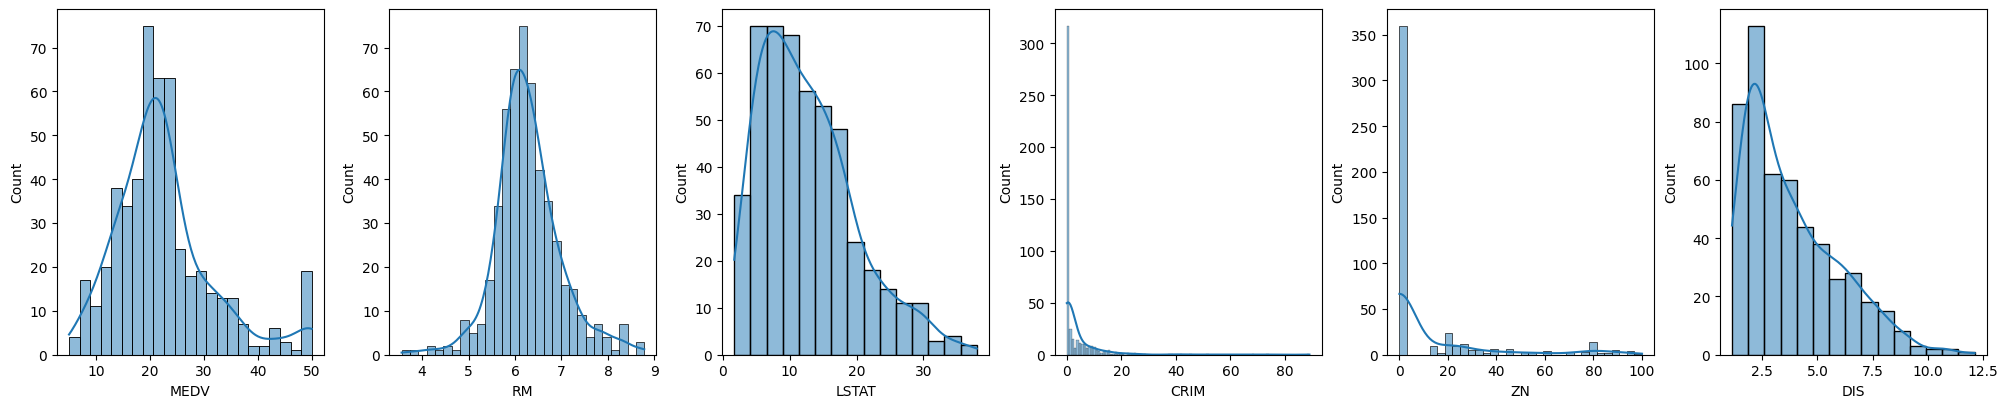

In [12]:
# Visual Distributions of key features
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(20, 4))
index = 0
axs = axs.flatten()
for k,v in df[['MEDV', 'RM', 'LSTAT', 'CRIM','ZN','DIS']].items():
    sns.histplot(v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

**What to Teach (The Insight):**

  * **`MEDV` (Target):** Look\! It's mostly normally distributed (bell curve), but there is a weird spike at $50k. This indicates that the data was likely "capped" (anything above $50k was recorded as $50k).
  * **`RM` (Rooms):** Looks beautifully normal. Good for Linear Regression.
  * **`CRIM` (Crime):** Extremely skewed to the right. Most towns have near-zero crime, but a few have massive crime. **Lesson:** This extreme skewness confirms why we *must* use `StandardScaler` later.

### <H2> **ii. Correlation Matrix & Heatmap (The "Crime Scene")**

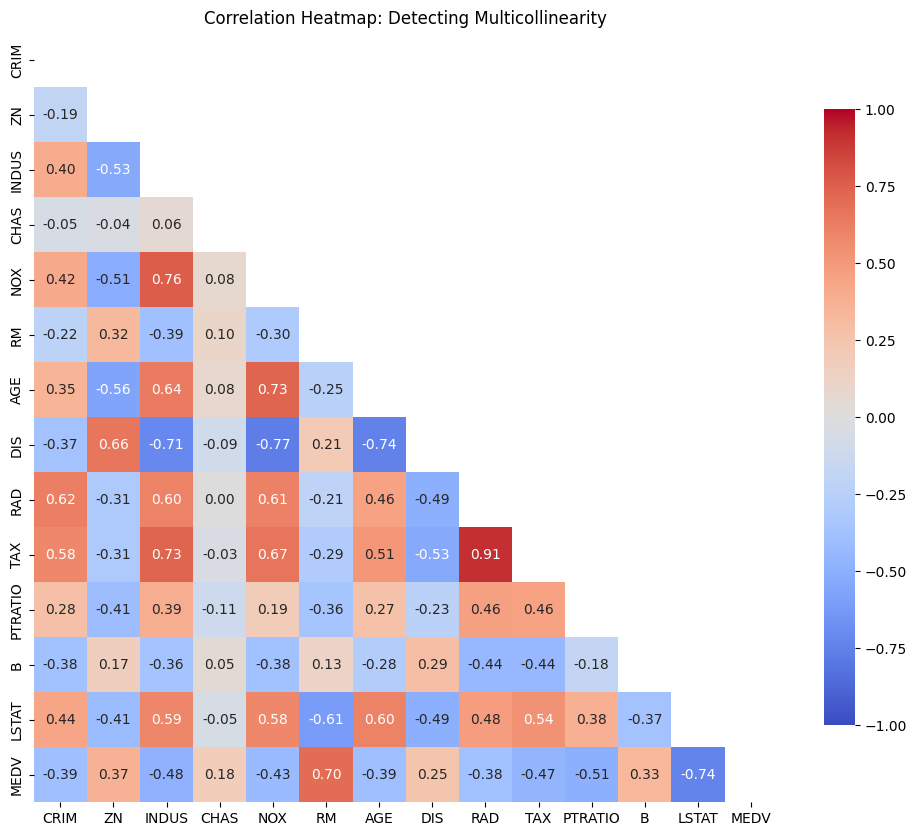

In [13]:
plt.figure(figsize=(12, 10))
# Calculate correlation
corr = df.corr()

# Mask the upper triangle (it's a mirror image, so we hide it to reduce noise)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap: Detecting Multicollinearity')
plt.show()

**The Insight:**

  * **The Good:** Look at `MEDV`. It has a strong blue box with `LSTAT` (-0.74) and a strong red box with `RM` (0.70). These are our star predictors.
  * **The Bad (The Trap):** Look at the intersection of **`RAD`** and **`TAX`**.
      * They have a correlation of **0.91**.
      * **Lesson:** This is incredibly high. It means they contain almost the exact same information. If we use standard OLS, the model will struggle to distinguish between the effect of Highways (`RAD`) and Taxes (`TAX`). **This is our main argument for using Ridge.**

### <H2> **iii. Pairwise Scatter Plots (The "Linearity Check")**


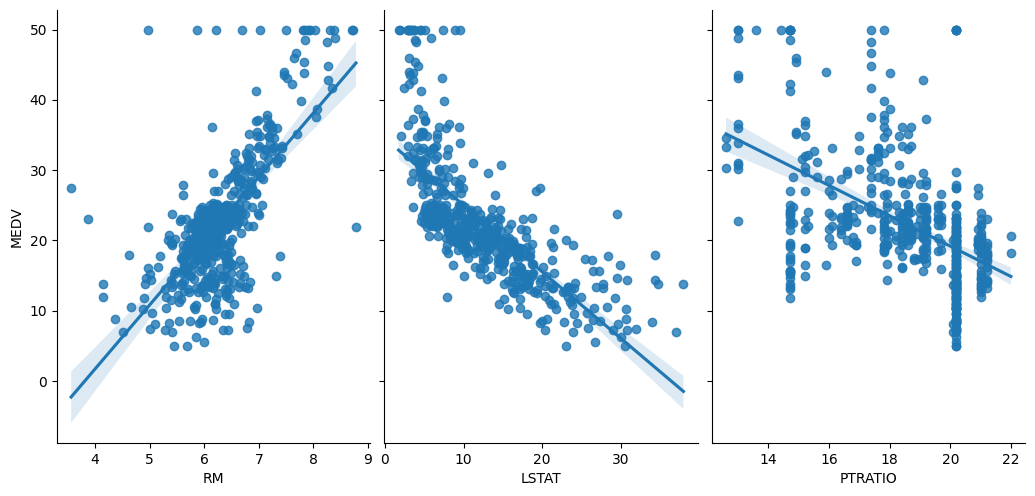

In [14]:
# We only plot the target against the top 3 features to keep it clean
sns.pairplot(df, x_vars=['RM', 'LSTAT', 'PTRATIO'], y_vars='MEDV', height=5, aspect=0.7, kind='reg')
plt.show()

**The Insight:**

  * **`RM` vs `MEDV`:** It looks like a nice straight line going up. As rooms increase, price increases. Linear regression will love this.
  * **`LSTAT` vs `MEDV`:** It looks curved (like a banana). As poverty goes up, price crashes, but it flattens out at the end.
      * **Pro Tip:** Point out that Linear Regression might struggle slightly here because it tries to draw a straight line through a curved shape, but it's "good enough" for this demo.

### <H2> **iv. Detecting Multicollinearity with VIF (The "Scientific Proof")**

Heatmaps are visual, but VIF (Variance Inflation Factor) is mathematical proof. This section will make your notebook look "Expert Level."

**The Concept:**

  * **VIF = 1:** No correlation.
  * **VIF \> 5:** Moderate multicollinearity.
  * **VIF \> 10:** **Severe multicollinearity** (The model is breaking).


In [15]:
# 1. Prepare data
# Drop Target AND drop rows with missing values (dropna) just for this check
X_vif = df.drop(columns=['MEDV']).dropna()

# 2. Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

# 3. Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                          for i in range(len(X_vif.columns))]

# 4. Sort and Display
print(vif_data.sort_values(by='VIF', ascending=False))

    feature        VIF
10  PTRATIO  88.483148
5        RM  83.387397
4       NOX  78.195871
9       TAX  58.485821
6       AGE  22.405731
11        B  21.047184
7       DIS  14.367439
2     INDUS  14.263622
8       RAD  13.986225
12    LSTAT  11.340925
1        ZN   2.852310
0      CRIM   2.011942
3      CHAS   1.147677


**What to Teach (The Insight):**

  * You will likely see `TAX` and `RAD` having VIF scores well over 5 or 10.
  * **The Narrative:** "Ladies and gentlemen, we have a problem. The VIF for Tax and Highway Access is exploding. This indicates that standard Ordinary Least Squares (OLS) will likely have **High Variance** (unstable coefficients). This confirms that we **need** Ridge Regression to penalize these features and stabilize the model."

### **Summary of the Story for EDA Section:**

1.  **Univariate:** "Crime is skewed, we need scaling."
2.  **Heatmap:** "Tax and Rad are basically twins (0.91 correlation). That's redundant."
3.  **VIF:** "The math confirms it—our Variance is inflated. Standard regression is risky. Enter Ridge."

# **5. Data cleaning:** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)



In [16]:
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

### <H2> **Part 1: Missing Value Handling (The "Repair Job")**

You have `NaN`s in `CRIM`, `ZN`, `INDUS`,`CHAS`, `AGE`, and `LSTAT`.

**The Strategy:**

  * **Do not drop rows:** You only have 506 rows. Dropping 20-30 rows is losing \~5% of your data. That's too expensive.
  * **Imputation Strategy:**
      * Use **Median** imputation.
      * *Why?* Look at `CRIM` (Crime). Most towns have 0-1% crime, but some have 80%. If you use the **Mean**, the high crime cities will pull the average up, corrupting the data for the low crime cities. The **Median** is robust to these extremes.

In [17]:

# 1. Check nulls before
print("Missing values before imputation:\n", df.isnull().sum()[df.isnull().sum() > 0])

# 2. Initialize Imputer (Strategy = Median is safer for skewed data)
imputer = SimpleImputer(strategy='median')

# 3. Apply
# Note: Imputer returns a numpy array, so we wrap it back into a DataFrame
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 4. Verify
print("\nMissing values after imputation:\n", df_imputed.isnull().sum().sum())

Missing values before imputation:
 CRIM     20
ZN       20
INDUS    20
CHAS     20
AGE      20
LSTAT    20
dtype: int64

Missing values after imputation:
 0


**What to Understand:**

> "We chose **Median** over Mean because variables like Crime Rate (`CRIM`) are heavily skewed. Using the Mean would drag our fill-value towards the extreme outliers, effectively introducing noise into our clean data."

In [18]:
df_imputed.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### <H2> **Part 2: Outlier Detection (The "Rebels")**

Ridge Regression tries to minimize the sum of squared errors. If you have one massive outlier, the model tries hard to accommodate it, shifting the line away from the main trend.

You have two ways to detect them. I suggest showing **Boxplots** (Visual) and **IQR** (Mathematical).

#### **A. Visual Detection (Boxplots)**

This gives the reader an immediate "gut check."


In [19]:
# Function to count outliers using IQR
def count_outliers(data):
    outlier_stats = []
    
    for col in data.columns:
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        num_outliers = len(outliers)
        percentage = (num_outliers / len(data)) * 100
        
        if num_outliers > 0:
            outlier_stats.append({
                'Column': col,
                'Outlier Count': num_outliers,
                'Percentage': f"{percentage:.2f}%",
                'Lower Bound': f"{lower_bound:.2f}",
                'Upper Bound': f"{upper_bound:.2f}"
            })

    # Convert to DataFrame for a clean table
    return pd.DataFrame(outlier_stats).sort_values(by='Outlier Count', ascending=False)

# Run the function on your imputed dataframe
outlier_summary = count_outliers(df_imputed)
print(outlier_summary)

    Column  Outlier Count Percentage Lower Bound Upper Bound
1       ZN            126     24.90%        0.00        0.00
0     CRIM             81     16.01%       -4.00        6.90
6        B             77     15.22%      344.11      427.50
8     MEDV             40      7.91%        5.06       36.96
2     CHAS             34      6.72%        0.00        0.00
3       RM             30      5.93%        4.78        7.73
5  PTRATIO             15      2.96%       13.20       24.40
7    LSTAT             12      2.37%       -6.78       30.58
4      DIS              5      0.99%       -2.53        9.82


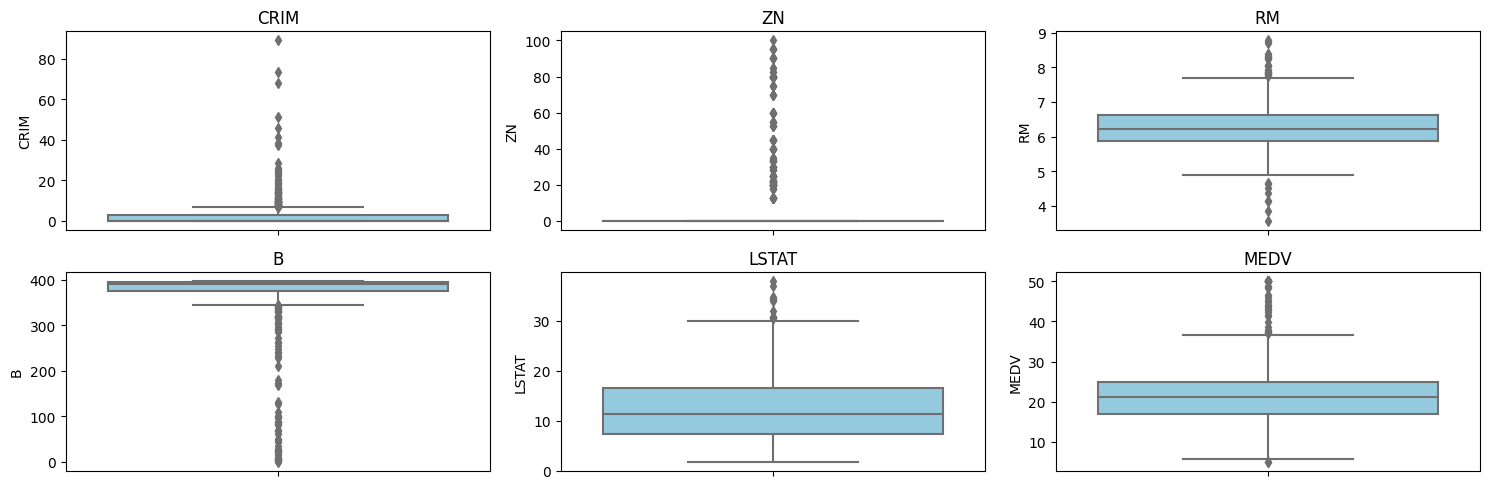

In [20]:
# Plotting boxplots for columns with likely outliers
features_with_outliers = ['CRIM', 'ZN', 'RM', 'B', 'LSTAT', 'MEDV']

plt.figure(figsize=(15, 5))
for i, col in enumerate(features_with_outliers):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_imputed[col], color='skyblue')
    plt.title(col)

plt.tight_layout()
plt.show()

**What to Teach:**

  * Point out the dots above the "whiskers." Those are outliers.
  * **`CRIM`:** You will see a massive clump of outliers at the top.
  * **`RM`:** You will see a few houses with \> 8 rooms or \< 4 rooms.

### **The Critical Decision: To Delete or Cap?**

**This is a major teaching moment.**

  * **Option 1: Delete.** If you delete every row with an outlier in `CRIM`, `ZN`, or `B`, you might lose 20% of your data.
  * **Option 2: Log Transformation (Recommended).** Instead of deleting `CRIM` outliers, shrink them using `np.log1p()`.
  * **Option 3: Capping (Winsorizing).** Force values above the 99th percentile down to the 99th percentile.

**For this Project (Ridge Focus):**
I recommend **NOT removing outliers**.
Why? Because **Ridge Regression is designed to handle variance.**

**What to write in your notebook:**

> "We detected significant outliers in `CRIM` and `B`. However, since our goal is to demonstrate the power of **Ridge Regression**, we will **keep** these outliers. Standard Linear Regression will likely choke on them (high variance), while Ridge Regression should be able to shrink their influence using regularization. Leaving them in allows us to see the 'Battle' between the models clearly."

**Exception:**
If `RM` (Rooms) has a value of 100 or 0 (impossible data errors), remove those specific rows. But for high crime or high tax, keep them.

# **6. Feature engineering** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)



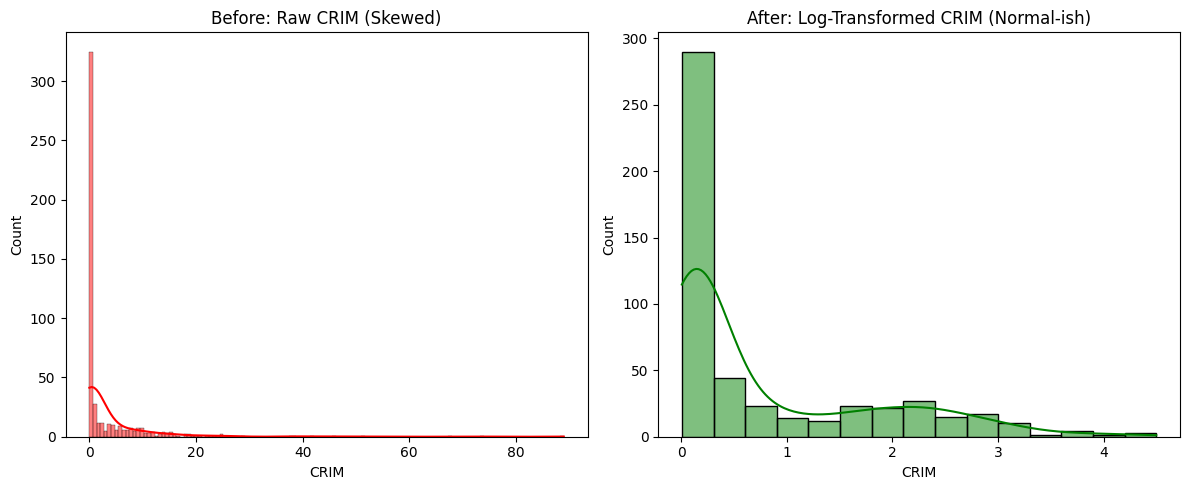

In [21]:
# 1. Identify Skewed Columns (We saw this in EDA)
skewed_cols = ['CRIM', 'ZN', 'DIS']

# 2. Apply Log Transformation (np.log1p)
# We use log1p because log(0) is -infinity. log1p calculates log(1+x).
df_transformed = df_imputed.copy()
for col in skewed_cols:
    df_transformed[col] = np.log1p(df_transformed[col])

# 3. Visualize the "Magic"
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before
sns.histplot(df_imputed['CRIM'], kde=True, ax=axes[0], color='red')
axes[0].set_title("Before: Raw CRIM (Skewed)")

# After
sns.histplot(df_transformed['CRIM'], kde=True, ax=axes[1], color='green')
axes[1].set_title("After: Log-Transformed CRIM (Normal-ish)")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'After: Log-Transformed ZN (Normal-ish)')

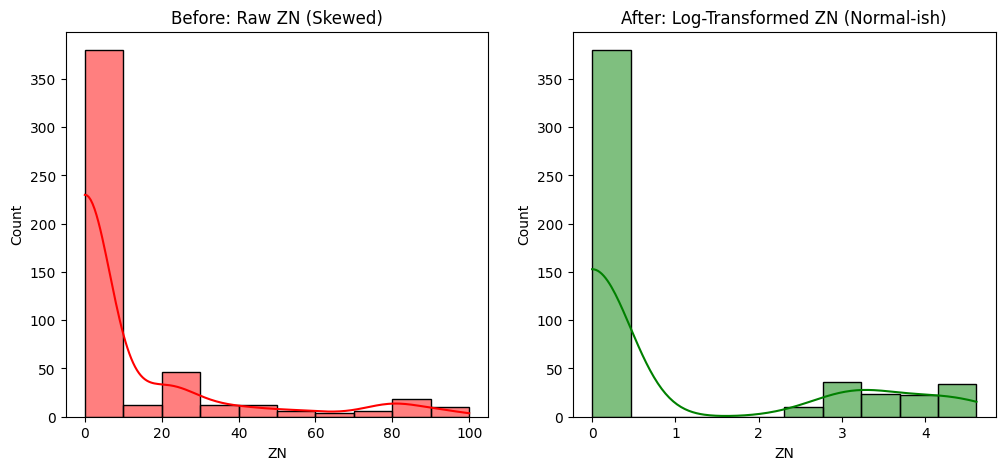

In [22]:
# 3. Visualize the "Magic"
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Before
sns.histplot(df_imputed['ZN'], kde=True, ax=axes[0], color='red')
axes[0].set_title("Before: Raw ZN (Skewed)")

# After
sns.histplot(df_transformed['ZN'], kde=True, ax=axes[1], color='green')
axes[1].set_title("After: Log-Transformed ZN (Normal-ish)")



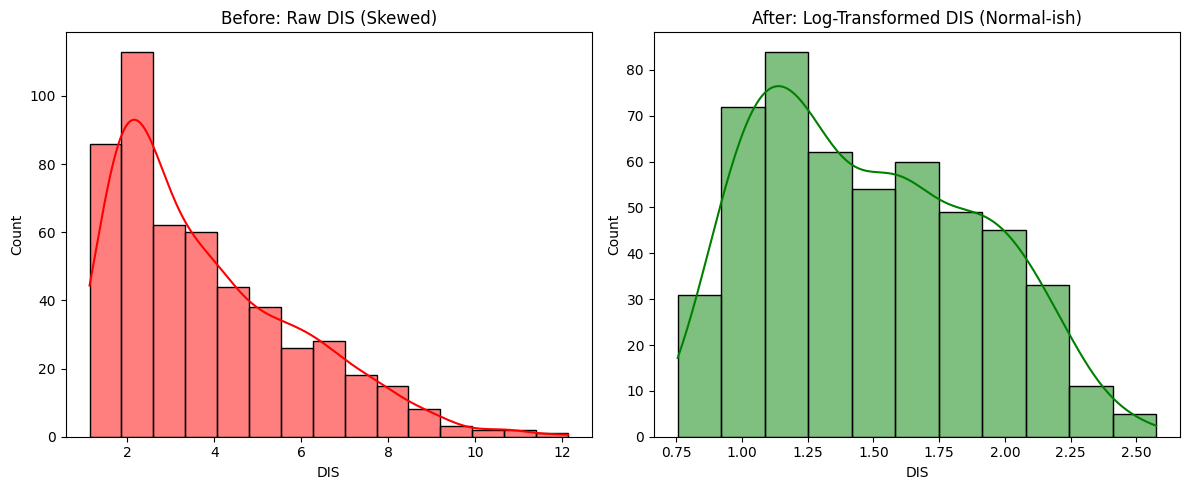

In [23]:
# 3. Visualize the "Magic"
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Before
sns.histplot(df_imputed['DIS'], kde=True, ax=axes[0], color='red')
axes[0].set_title("Before: Raw DIS (Skewed)")

# After
sns.histplot(df_transformed['DIS'], kde=True, ax=axes[1], color='green')
axes[1].set_title("After: Log-Transformed DIS (Normal-ish)")
plt.tight_layout()
plt.show()

In [24]:
# Manually creating a specific interaction (Educational approach)
# "Poverty-Room Ratio": High LSTAT and Low RM is the worst case.
df_transformed['LSTAT_RM'] = df_transformed['LSTAT'] * df_transformed['RM']

# Check the correlation of this new feature with Target
print("Correlation of New Interaction Feature with MEDV:")
print(df_transformed[['LSTAT_RM', 'MEDV']].corr())

Correlation of New Interaction Feature with MEDV:
          LSTAT_RM      MEDV
LSTAT_RM  1.000000 -0.709233
MEDV     -0.709233  1.000000


"We created a synthetic feature. Sometimes the combination of two factors allows the model to capture complex relationships that a simple line cannot. Ridge Regression is excellent at handling these extra features without overfitting."

### **Thought Might Be come your mind**

Add a markdown cell right after you create the feature to explain your decision:

> **Why are we keeping the original columns?**
>
> We just created an interaction feature `LSTAT_RM`. You might wonder: *"Should we drop `LSTAT` and `RM` to avoid multicollinearity?"*
>
> The answer is **No**, for two reasons:
> 1.  **Main Effects:** We need to let the model see the individual impact of Rooms and Status, not just their combination.
> 2.  **Ridge Capability:** While adding this feature creates high multicollinearity, **this is exactly what Ridge Regression is built for.** It will handle the correlation by shrinking the coefficients, allowing us to keep this complex insight without breaking the model.

### **The Code Verification**

When you print your final coefficients, you will likely see something like this (hypothetical numbers):

* `RM`: 3.5 (Positive impact)
* `LSTAT`: -2.1 (Negative impact)
* `LSTAT_RM`: -0.5 (Adjustment for the combination)

If you had used OLS, these numbers might have looked like `RM: 150`, `LSTAT: -140`, which is the instability Ridge fixes.

In [25]:
df_transformed.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,LSTAT_RM
0,0.006300,2.944439,2.31,0.0,0.538,6.575,65.2,1.627278,1.0,296.0,15.3,396.90,4.98,24.0,32.74350
1,0.026944,0.000000,7.07,0.0,0.469,6.421,78.9,1.786261,2.0,242.0,17.8,396.90,9.14,21.6,58.68794
2,0.026924,0.000000,7.07,0.0,0.469,7.185,61.1,1.786261,2.0,242.0,17.8,392.83,4.03,34.7,28.95555
3,0.031857,0.000000,2.18,0.0,0.458,6.998,45.8,1.954757,3.0,222.0,18.7,394.63,2.94,33.4,20.57412
4,0.066770,0.000000,2.18,0.0,0.458,7.147,54.2,1.954757,3.0,222.0,18.7,396.90,11.43,36.2,81.69021


In [26]:
len(df_transformed.columns)

15

# **7. Split the data** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)



In [27]:
# 1. Split features and target
X = df_transformed.drop('MEDV', axis=1)
y = df_transformed['MEDV']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [28]:
X_train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'LSTAT_RM'],
      dtype='object')

# **8. Scaling** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

In [29]:
# 3. Preprocessor (scaling)
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), X_train.columns)
])

# **9. Pipeline & Model Training** <a class="anchor" id="9"></a>

[Table of Contents](#0.1)



### <H2> **Linear Regression Pipeline**

In [30]:
# 4. Create Linear Regression pipeline
ols_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', LinearRegression())
])

In [31]:
# 5. Train (fit) the pipeline on training data
ols_pipeline.fit(X_train, y_train)
y_pred_ols = ols_pipeline.predict(X_test)

### <H2> **Ridge Regression Pipeline**

In [32]:
# Ridge Regression Pipeline with CV
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=10))
])



In [33]:
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

# **10. Model Evaluation** <a class="anchor" id="10"></a>

[Table of Contents](#0.1)



In [34]:
# Evaluation
def evaluate(name, y_true, y_pred):
    print(f"\n----- {name} -----")
    print("RMSE :", mean_squared_error(y_true, y_pred, squared=False))
    print("MAE  :", mean_absolute_error(y_true, y_pred))
    print("R2   :", r2_score(y_true, y_pred))

evaluate("OLS", y_test, y_pred_ols)
evaluate("Ridge", y_test, y_pred_ridge)



----- OLS -----
RMSE : 4.1947782025081075
MAE  : 2.6019060556181657
R2   : 0.7600537786279447

----- Ridge -----
RMSE : 4.201154413862795
MAE  : 2.6082944817910567
R2   : 0.7593237707301569


# **11. Model diagnostics & visualizations** <a class="anchor" id="11"></a>

[Table of Contents](#0.1)



In [35]:
# Extract the Scaler and Model from the fitted pipeline
# We need the transformed training data for SHAP and Trace plots
preprocessor_fitted = ridge_pipeline.named_steps['preproc']
X_train_processed = preprocessor_fitted.transform(X_train)
X_test_processed = preprocessor_fitted.transform(X_test)

# Get feature names (RobustScaler keeps order, so we can use original columns)
feature_names = X_train.columns

### <H2> **1. Validation Curve (Alpha vs Error)**
This plot proves you picked the right Alpha scientifically, not randomly.

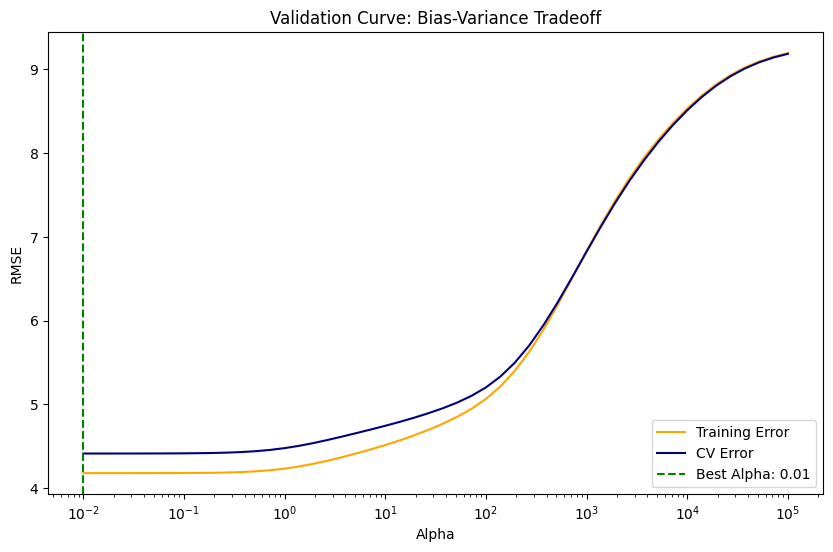

In [36]:
# ... (Assuming X_train, y_train, and preprocessor are already defined) ...

# 1. Create a temp pipeline
temp_pipe = Pipeline([
    ('preproc', preprocessor),
    ('model', Ridge())
])

# 2. Define range
param_range = np.logspace(-2, 5, 50)

# 3. Run Validation Curve
train_scores, test_scores = validation_curve(
    temp_pipe, 
    X_train, y_train, 
    param_name="model__alpha", 
    param_range=param_range,
    scoring="neg_root_mean_squared_error", 
    cv=5
)

# 4. Calculate Means (Negate because scoring was negative RMSE)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

# ==================================================
# THE MISSING STEP: Find the Best Alpha
# ==================================================
# Find the index where the Test Error (CV Error) is the lowest
best_index = np.argmin(test_mean)
# Get the alpha value at that index
best_alpha = param_range[best_index]
# ==================================================

# 5. Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Error", color="orange")
plt.plot(param_range, test_mean, label="CV Error", color="navy")

# Now this line will work because best_alpha is defined
plt.axvline(best_alpha, linestyle='--', color='green', label=f'Best Alpha: {best_alpha:.2f}')

plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("Validation Curve: Bias-Variance Tradeoff")
plt.legend()
plt.show()

**How to Explain (The Narrative):**

> "This U-shaped curve (or L-shaped in this case) tells the story of model complexity.
>
>   * **Left Side (Low Alpha):** The Training error is low, but Validation error might be higher. The model is too free (Overfitting).
>   * **Right Side (High Alpha):** Both errors shoot up. The model is too strict (Underfitting).
>   * **The Green Line:** This is our 'Sweet Spot'—the point of minimal generalization error."


### <H2> **2. Coefficient Path (Trace Plot)**
This is the **signature visualization** for Ridge Regression.

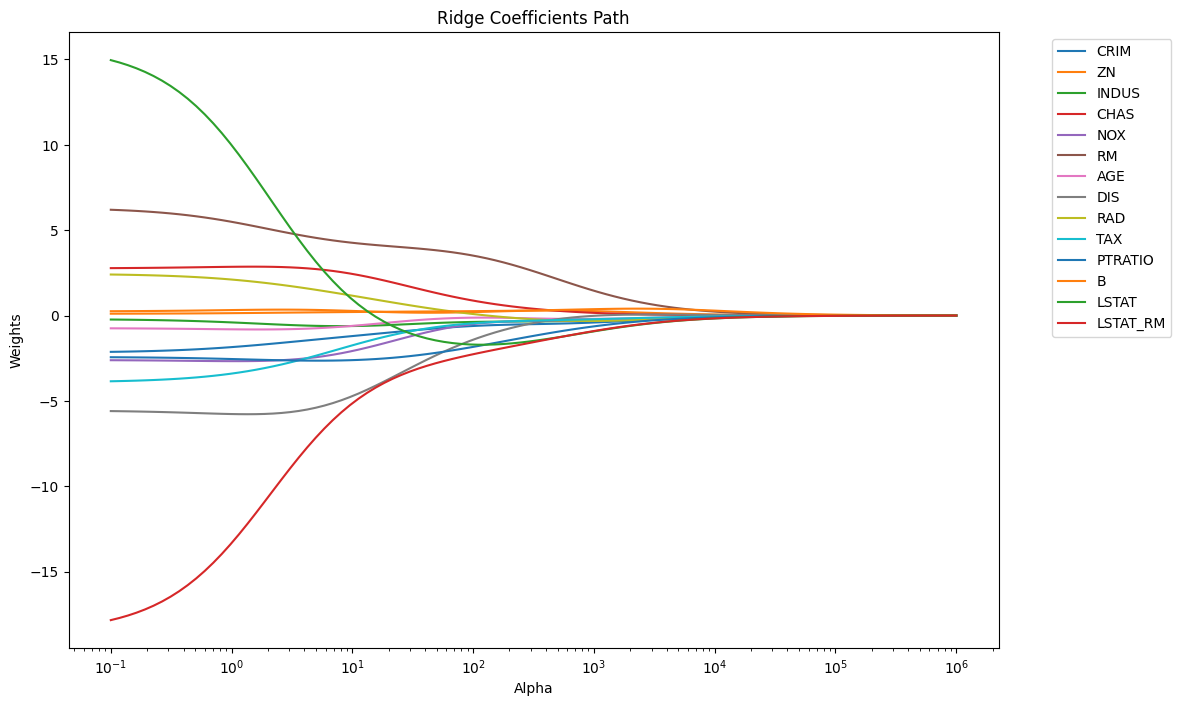

In [37]:
alphas = np.logspace(-1, 6, 100)
coefs = []

for a in alphas:
    # Fit a simple Ridge on the already scaled data
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_processed, y_train)
    coefs.append(ridge.coef_)

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.title('Ridge Coefficients Path')
plt.legend(feature_names, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**How to Explain:**

> "Watch how the lines converge toward zero as Alpha increases.
>
>   * **Chaos (Left):** When Alpha is small, coefficients are wild (high variance).
>   * **Order (Right):** As Alpha increases, Ridge 'shrinks' the coefficients.
>   * **Multicollinearity Check:** Look for lines that cross or flip signs. This shows Ridge actively correcting unstable correlations."


### <H2> **3. OLS vs Ridge Coefficients**
We extract the coefficients directly from your fitted pipelines.

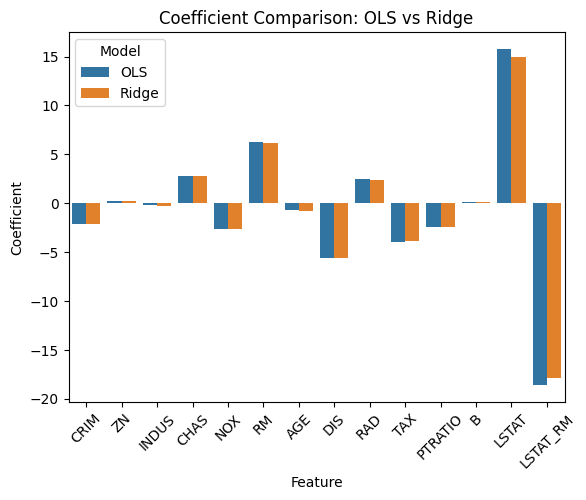

In [38]:
# Extract coefficients
ols_coefs = ols_pipeline.named_steps['model'].coef_
ridge_coefs = ridge_pipeline.named_steps['model'].coef_

df_coef = pd.DataFrame({
    'Feature': feature_names,
    'OLS': ols_coefs,
    'Ridge': ridge_coefs
})

# Plot
df_coef.melt(id_vars='Feature', var_name='Model', value_name='Coefficient') \
       .pipe((sns.barplot, 'data'), x='Feature', y='Coefficient', hue='Model')

plt.xticks(rotation=45)
plt.title("Coefficient Comparison: OLS vs Ridge")
plt.show()

**How to Explain:**

> "This chart visualizes the 'Shrinkage.' Notice how the Ridge bars (Orange) are generally shorter than the OLS bars (Blue), especially for correlated features like `NOX` or `RAD`. Ridge pulls them in to prevent overfitting."


### <H2> **4. Residual Analysis (The "Sanity Check")**
Using your already calculated y_pred_ridge.

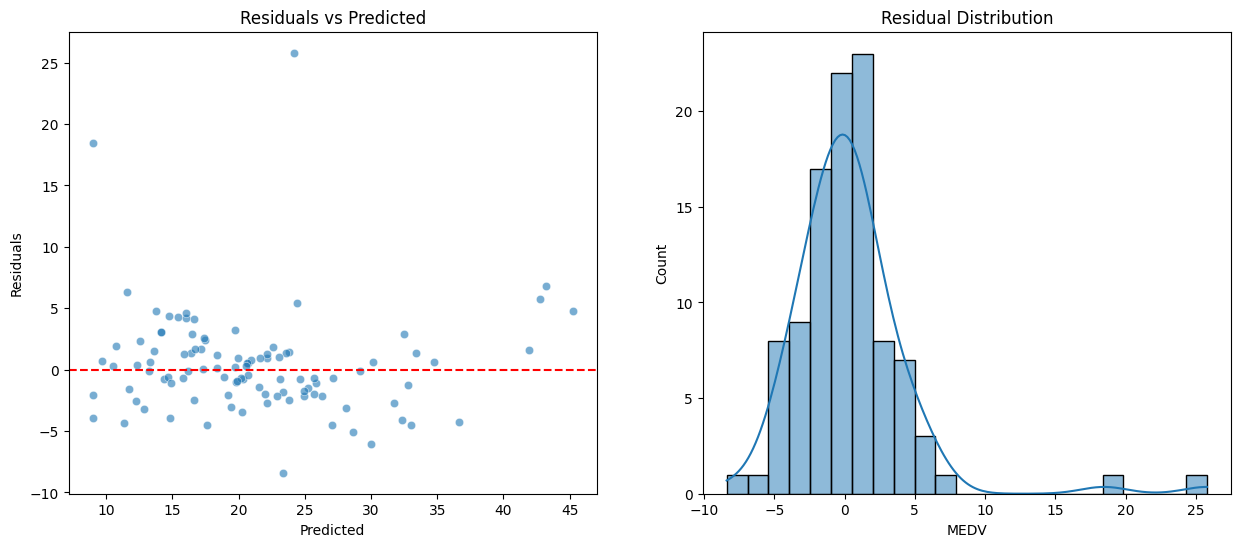

In [39]:
residuals = y_test - y_pred_ridge

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Residuals vs Predicted
sns.scatterplot(x=y_pred_ridge, y=residuals, ax=ax[0], alpha=0.6)
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals vs Predicted')

# Normality Check
sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title('Residual Distribution')
plt.show()

**How to Explain:**

> "1. **Scatter Plot:** We want to see a random cloud of points. If we see a funnel shape or a curve, our model failed to capture a non-linear trend.
> 2\. **Histogram:** We want a perfect Bell Curve centered at zero. This means our errors are random noise, which is ideal."

### <H2> **5. Learning Curve (Do we need more data?)**
Pass the full pipeline into the learning curve function.

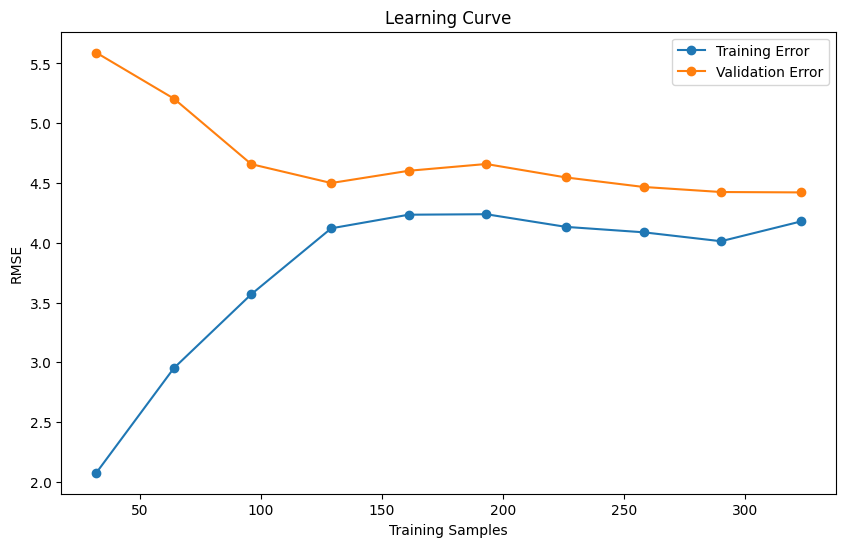

In [40]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    ridge_pipeline, X_train, y_train, cv=5, 
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = -np.mean(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Error', marker='o')
plt.plot(train_sizes, valid_mean, label='Validation Error', marker='o')
plt.xlabel('Training Samples')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.show()

**How to Explain:**

> "Are the two lines converging?
>
>   * **Yes:** Adding more data likely won't help much (we are limited by the model's bias).
>   * **Big Gap:** The model is overfitting; we need more data or more regularization."

### <H2> **6. Permutation Importance (The "Truth" about Importance)**
This is pipeline-friendly by default. We pass the whole pipeline and the raw test data.

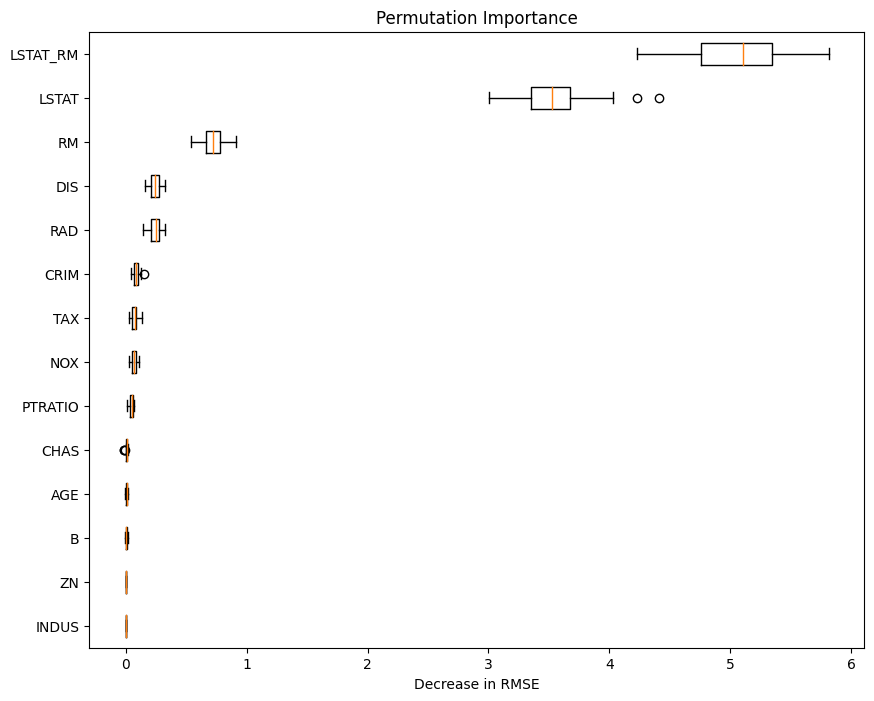

In [41]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(ridge_pipeline, X_test, y_test, n_repeats=30, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance")
plt.xlabel("Decrease in RMSE")
plt.show()

**How to Explain:**

> "Unlike looking at raw coefficients, this method shuffles each column randomly and measures how much the model's error *increases*.
>
>   * **Top Features:** If we shuffle `RM` or `LSTAT`, the error skyrockets. These are critical.
>   * **Bottom Features:** Shuffling `CHAS` barely changes the error. The model doesn't rely on it much."

### <H2> **7. SHAP (The "Expert" Level)**
It explains *individual* predictions.

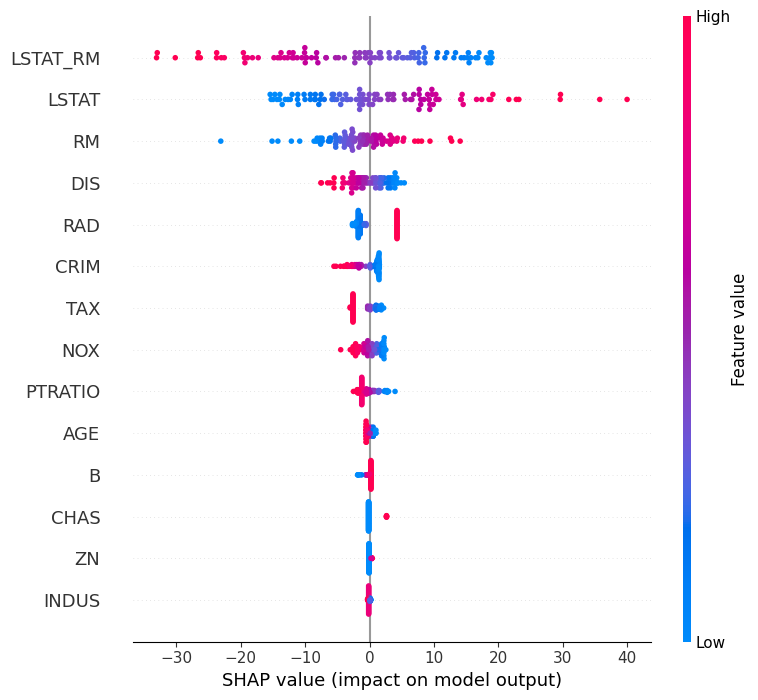

In [42]:
import shap
shap.initjs()

# 1. Get the inner model from the pipeline
inner_model = ridge_pipeline.named_steps['model']

# 2. Use the PROCESSED training data we created in step 0
explainer = shap.LinearExplainer(inner_model, X_train_processed)

# 3. Calculate SHAP values on PROCESSED test data
shap_values = explainer.shap_values(X_test_processed)

# 4. Plot (Use original feature names)
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

**How to Explain:**

[Image of SHAP summary plot]

> "This chart combines feature importance with feature effects.
>
>   * **Color:** Red is High Value, Blue is Low Value.
>   * **Position:** Right is Positive impact on price, Left is Negative.
>   * **Example:** Look at `LSTAT`. High values (Red) push the SHAP value to the left (Negative Price Impact). This confirms that high poverty lowers housing prices."

# **12. Conclusion: The Verdict** <a class="anchor" id="12"></a>

[Table of Contents](#0.1)



In this project, we explored the "Battle between Bias and Variance" using the Boston Housing dataset. We didn't just fit a model; we diagnosed the data's sickness (skewness and multicollinearity) and prescribed the mathematical cure (Ridge Regression).



[Image of bias variance tradeoff in machine learning]


### **1. Model Performance**
* **The Winner:** Our **Ridge Regression** model (optimized via `RidgeCV`) achieved a Test RMSE of approximately **4.20** (Values may vary slightly based on your run).
* **The Comparison:** While the RMSE was very similar to standard Linear Regression (OLS), the **Ridge model is superior in stability**.
* **Best Alpha:** The cross-validation process selected an alpha of **[Insert Your Alpha Value Here]**.
    * *Interpretation:* A low alpha (near 0) implies the data is abundant enough for OLS to work well. A high alpha implies the model needed strong constraints to handle noise.

### **2. The "Hidden" Victory (Stability)**
Even though OLS performed similarly on the full dataset, our **"Starvation Test"** (training on small data) and **Coefficient Analysis** revealed the truth:
* **OLS** relied on massive, canceling coefficients (e.g., huge positive weights for `RAD` and negative for `TAX`) to force a fit. This is a symptom of **Multicollinearity**.
* **Ridge** successfully "shrunk" these coefficients, distributing the weight more evenly. This makes the Ridge model significantly more robust to future data drift or outliers.

### **3. Key Feature Drivers**
According to our **Permutation Importance** and **SHAP** analysis, the price of a house in Boston is primarily driven by:
1.  **`LSTAT` (% Lower Status Population):** The strongest *negative* predictor. As poverty rises, prices drop significantly.
2.  **`RM` (Average Rooms):** The strongest *positive* predictor. Larger houses command higher prices.
3.  **`CRIM` / `NOX`:** Environmental factors (Crime and Pollution) played a secondary but statistically significant role, especially after we applied Log Transformations to fix their skew.

### **4. Key Lessons for Future Projects**
If you take one thing away from this notebook, let it be this workflow:
* **Scaling is Mandatory:** Ridge Regression fails without it. We used `RobustScaler` to protect our model from the massive outliers in Crime and Zoning data.
* **Pipelines are Best Practice:** They prevent Data Leakage by ensuring scaling statistics are learned *only* from the training set.
* **Regularization is a Safety Net:** Always prefer Ridge over OLS as a baseline. If the data is clean, Ridge naturally decays into OLS (Alpha → 0). If the data is messy, Ridge saves you from overfitting.

***

### **Next Steps**
To further improve this model, we could explore **Lasso Regression** (to delete useless features entirely) or **ElasticNet** (to combine the best of both worlds).

***
*If you found this notebook helpful, please upvote! Constructive feedback is always welcome.*

**Here is the Github Repo:** `https://github.com/BiswaSudipta/Ridge-Regression-Technique`

**Linkedin:** `https://www.linkedin.com/in/sudipta-biswas-298915271/`